# Модуль 2. Классификация изображений


## Сопоставление изображений


### Алгоритмы сопоставления изображений

Для реализации алгоритма классификации изображений, я предложу вам пример кода, использующий библиотеку tensorflow и keras. В этом примере мы будем использовать предварительно обученную модель MobileNetV2 для классификации изображений.

Прежде всего, убедитесь, что у вас установлены tensorflow и keras


In [ ]:
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import (
    preprocess_input,
    decode_predictions,
)
from tensorflow.keras.preprocessing import image

# Загрузка предварительно обученной модели MobileNetV2
model = MobileNetV2(weights="imagenet")


def classify_image(img_path):
    # Загрузка изображения, его предварительная обработка и расширение размерностей
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    preprocessed_image = preprocess_input(img_array_expanded_dims)

    # Прогнозирование и декодирование предсказаний
    predictions = model.predict(preprocessed_image)
    results = decode_predictions(predictions, top=3)[0]

    # Вывод результатов
    for i, (imagenet_id, label, score) in enumerate(results):
        print(f"{i + 1}: {label} ({score*100:.2f}%)")


# Пример использования
img_path = "./data/texture_01.jpg"
classify_image(img_path)

### Построение мозаики из изображений

Для построения мозаики изображений на Python, можно использовать библиотеку PIL (Python Imaging Library), которая теперь доступна как Pillow. Ниже приведен пример кода, который создает мозаику из нескольких изображений. Допустим, у нас есть четыре изображения, и мы хотим их объединить в одно большое изображение-мозаику в формате 2x2.

Прежде всего, убедитесь, что у вас установлена библиотека Pillow


In [23]:
from PIL import Image


def crop_to_square(img, size):
    """
    Обрезка изображения до квадратной формы по центру.
    """
    # Определение текущих размеров
    width, height = img.size

    # Определение размера для обрезки
    new_size = min(width, height, size)

    # Вычисление координат для обрезки
    left = (width - new_size) / 2
    top = (height - new_size) / 2
    right = (width + new_size) / 2
    bottom = (height + new_size) / 2

    # Обрезка и возврат изображения
    img = img.crop((left, top, right, bottom))
    return img.resize((size, size), Image.Resampling.LANCZOS)


# Пути к изображениям, которые будут включены в мозаику
image_paths = ["image1.jpg", "image2.jpg", "image3.jpg", "image4.jpg"]

# Открытие изображений и их сохранение в список
images = [Image.open(f"./data/{x}") for x in image_paths]

# Определение минимального размера среди всех изображений
min_size = min(min(img.size) for img in images)

# Обрезка изображений до квадратов и изменение их размера
squared_images = [crop_to_square(img, min_size) for img in images]

# Создание нового пустого изображения для мозаики
mosaic_size = (min_size * 2, min_size * 2)
mosaic_image = Image.new("RGB", mosaic_size, (255, 255, 255))

# Размещение изображений в мозаике
positions = [(0, 0), (min_size, 0), (0, min_size), (min_size, min_size)]
for img, pos in zip(squared_images, positions):
    mosaic_image.paste(img, pos)

# Сохранение и показ мозаики
mosaic_image.save("./result/mosaic.jpg")
mosaic_image.show()

## CNN

Используем набор данных CIFAR10. Имеет классы: «самолет», «автомобиль», «птица», «кошка», «олень», «собака», «лягушка», «лошадь», «корабль», «грузовик». Изображения в CIFAR-10 имеют размер 3х32х32, т.е. 3-канальные цветные изображения размером 32х32 пикселей.


## Загрузите и нормализуйте CIFAR10.

> Если вы работаете в Windows и получаете ошибку BrokenPipeError, попробуйте установить для num_worker torch.utils.data.DataLoader() значение 0.

Выходными данными наборов данных torchvision являются изображения PILImage диапазона [0, 1]. Мы преобразуем их в тензоры нормализованного диапазона [-1, 1].


In [26]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

Files already downloaded and verified
Files already downloaded and verified


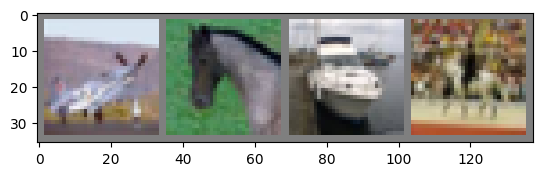

plane horse ship  horse


In [27]:
# Посмотрим обучающие данные
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(" ".join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))

## Определите сверточную нейронную сеть

Скопируйте нейронную сеть из раздела «Нейронные сети» ранее и измените ее, чтобы она получала 3-канальные изображения (вместо 1-канальных изображений, как было определено).


In [28]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## Определите функцию потерь и оптимизатор.

Давайте используем классификационную кросс-энтропийную потерю и SGD с импульсом.


In [29]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Обучите сеть

- Выполним цикл по нашему итератору данных, передать входные данные в сеть и оптимизировать.
- Сохраним нашу обученную модель


In [30]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}")
            running_loss = 0.0

print("Finished Training")

PATH = "./cifar_net.pth"
torch.save(net.state_dict(), PATH)

[1,  2000] loss: 2.196
[1,  4000] loss: 1.846
[1,  6000] loss: 1.686
[1,  8000] loss: 1.573
[1, 10000] loss: 1.509
[1, 12000] loss: 1.463
[2,  2000] loss: 1.406
[2,  4000] loss: 1.363
[2,  6000] loss: 1.344
[2,  8000] loss: 1.326
[2, 10000] loss: 1.313
[2, 12000] loss: 1.266
Finished Training


## Протестируйте сеть на тестовых данных.

Мы обучили сеть за два прохода по набору обучающих данных. Но нам нужно проверить, узнала ли сеть вообще что-нибудь.

Мы проверим это, предсказав метку класса, которую выдает нейронная сеть, и проверив ее на соответствие истине. Если прогноз верен, мы добавляем образец в список правильных прогнозов.

Покажем изображение из тестового набора для ознакомления.


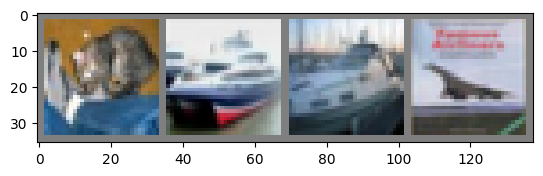

GroundTruth:  cat   ship  ship  plane


<All keys matched successfully>

In [33]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", " ".join(f"{classes[labels[j]]:5s}" for j in range(4)))

# Далее давайте снова загрузим нашу сохраненную модель (примечание: сохранение и повторная загрузка модели здесь не требовалось, мы сделали это только для иллюстрации того, как это сделать):
net = Net()
net.load_state_dict(torch.load(PATH))

In [34]:
# Посмотрим, что думает нейронная сеть в приведенных выше примерах
outputs = net(images)
# Выходные данные представляют собой энергии для 10 классов. Чем выше энергия класса, тем больше сеть считает, что изображение принадлежит определенному классу. Итак, получим индекс наивысшей энергии:
_, predicted = torch.max(outputs, 1)

print("Predicted: ", " ".join(f"{classes[predicted[j]]:5s}" for j in range(4)))

Predicted:  cat   car   car   plane


In [35]:
# посмотрим, как сеть работает со всем набором данных.
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the 10000 test images: {100 * correct // total} %")
# случайный выбор класса из 10 классов даст точность 10%

Accuracy of the network on the 10000 test images: 56 %


In [36]:
# какие классы показали хорошие результаты?

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f"Accuracy for class: {classname:5s} is {accuracy:.1f} %")

Accuracy for class: plane is 54.4 %
Accuracy for class: car   is 58.3 %
Accuracy for class: bird  is 42.5 %
Accuracy for class: cat   is 47.9 %
Accuracy for class: deer  is 48.0 %
Accuracy for class: dog   is 43.3 %
Accuracy for class: frog  is 72.1 %
Accuracy for class: horse is 62.9 %
Accuracy for class: ship  is 63.9 %
Accuracy for class: truck is 76.3 %


## Обучение на GPU


In [ ]:
# Точно так же, как вы переносите тензор на графический процессор, вы переносите нейронную сеть на графический процессор.
# Cначала определим наше устройство как первое видимое устройство cuda, если у нас есть доступный CUDA:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)  # cuda:0

# В оставшейся части этого раздела предполагается, что deviceэто устройство CUDA.

# Затем эти методы рекурсивно пройдут по всем модулям и преобразуют их параметры и буферы в тензоры CUDA:

net.to(device)

# придется отправлять входные данные и цели на каждом этапе в графический процессор

inputs, labels = data[0].to(device), data[1].to(device)